<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%200dB%20NOISE%20in%20CWRU%20Dataset%20250623.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [4]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_0_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/Normal_099.mat
['Normal_099']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/OR021_6_1_240.mat
['Normal_099' 'OR021_6_1_240']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/IR021_1_215.mat
['Normal_099' 'OR021_6_1_240' 'IR021_1_215']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/B021_1_228.mat
['Normal_099' 'OR021_6_1_240' 'IR021_1_215' 'B021_1_228']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/OR014_6_1_203.mat
['Normal_099' 'OR021_6_1_240' 'IR021_1_215' 'B021_1_228' 'OR014_6_1_203']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/B014_1_191.mat
['Normal_099' 'OR021_6_1_240' 'IR021_1_215' 'B021_1_228' 'OR014_6_1_203'
 'B014_1_191']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/OR007_6_1_137.mat
['Normal_099' 'OR021_6_1_240' 'IR021_1_215' 'B021_1_228' 'OR014_6_1_203'
 'B014_1_191' 'OR007_6_1_137']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/B007_1_124.mat
['Normal_099' 'OR021_6_1_240' 'IR021_1_215' 'B021_1_228' 'OR014_6_1_203'
 'B014_1_191' 

# Multi-Kernel Deep 1D-CNN

In [5]:
pip install tensorflow

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2437, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2437, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2437, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2238, 64)  │     12,864 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2338, 64)  │      6,464 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2388, 64)  │      3,264 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2238, 64)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2338, 64)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2388, 64)  │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 111, 64)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 233, 64)   │          0 │ dropout_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 477, 64)   │          0 │ dropout_2[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7104)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 14912)     │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 30528)     │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 52544)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │  5,254,500 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9)         │        909 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,278,001 (20.13 MB)

 Trainable params: 5,278,001 (20.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 574ms/step - accuracy: 0.1624 - loss: 3.8801 - val_accuracy: 0.2700 - val_loss: 1.7797
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3783 - loss: 1.5542 - val_accuracy: 0.5252 - val_loss: 1.3873
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5758 - loss: 1.1091 - val_accuracy: 0.5445 - val_loss: 1.1185
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6694 - loss: 0.7848 - val_accuracy: 0.7285 - val_loss: 0.8996
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8483 - loss: 0.5652 - val_accuracy: 0.8546 - val_loss: 0.6767
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9247 - loss: 0.3797 - val_accuracy: 0.8650 - val_loss: 0.5414
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9494 - loss: 0.2520 - val_accuracy: 0.9392 - val_loss: 0.4032
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9709 - loss: 0.1679 - val_accuracy: 0.9347 -

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


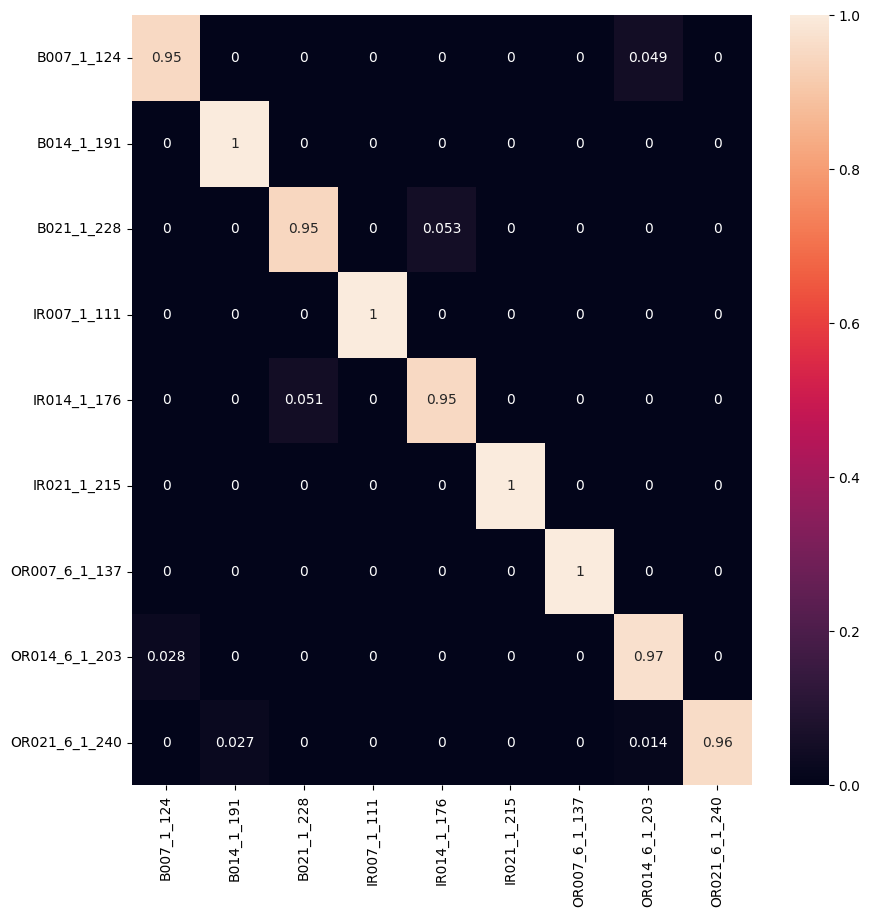

In [11]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [12]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1570 samples in 0.001s...
[t-SNE] Computed neighbors for 1570 samples in 0.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1570
[t-SNE] Computed conditional probabilities for sample 1570 / 1570
[t-SNE] Mean sigma: 3.914005
[t-SNE] Computed conditional probabilities in 0.064s
[t-SNE] Iteration 50: error = 57.1339264, gradient norm = 0.0395586 (50 iterations in 0.610s)
[t-SNE] Iteration 100: error = 52.1966400, gradient norm = 0.0138495 (50 iterations in 0.417s)
[t-SNE] Iteration 150: error = 51.0429993, gradient norm = 0.0094200 (50 iterations in 0.442s)
[t-SNE] Iteration 200: error = 50.4908104, gradient norm = 0.0073972 (50 iterations in 0.418s)
[t-SNE] Iteration 250: error = 50.1597672, gradient norm = 0.0050851 (50 iterations in 0.410s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.159767
[t-SNE] Iteration 300: error = 0.8872750, gradient norm = 0.0167392 (50 iterations in 0.442s

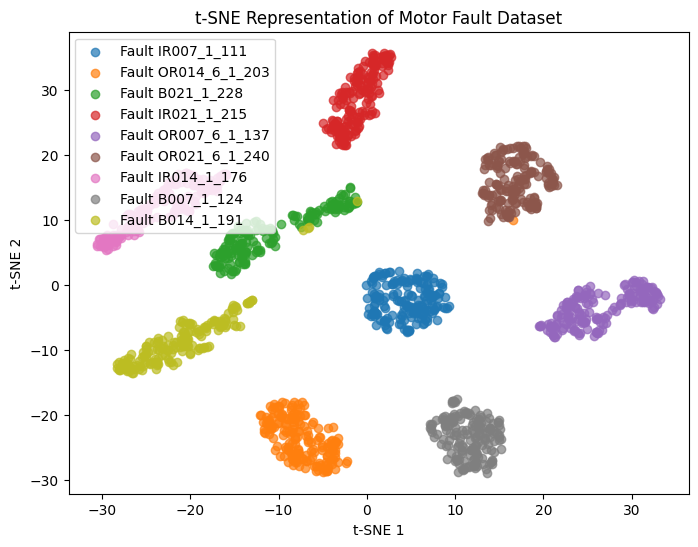

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

Statistical Features

In [15]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Convert window to a numeric type
        window = window.astype(float)

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")

Calculated WINDOW_SIZE: 2437, STRIDE: 1949
Extracted 2244 rows (target: 1800)
              fault  window      mean       std       rms       max       min  \
0     OR021_6_1_240       1  0.015607  0.492382  0.492629  3.210128 -3.966336   
1     OR021_6_1_240       2  0.015350  0.646707  0.646889  4.917856 -4.585659   
2     OR021_6_1_240       3  0.014072  0.669473  0.669621  3.917091 -4.262643   
3     OR021_6_1_240       4  0.014014  0.701110  0.701250  3.917091 -4.262643   
4     OR021_6_1_240       5  0.014971  0.529179  0.529391  3.437992 -4.165821   
...             ...     ...       ...       ...       ...       ...       ...   
2239    IR014_1_176     246  0.013869  0.293245  0.293573  1.901788 -1.770328   
2240    IR014_1_176     247  0.015376  0.296763  0.297161  1.901788 -1.770328   
2241    IR014_1_176     248  0.016397  0.318915  0.319336  2.213536 -2.146763   
2242    IR014_1_176     249  0.018091  0.123074  0.124397  0.709049 -0.772901   
2243    IR014_1_176     250  0.

In [16]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
IR021_1_215      251
OR021_6_1_240    250
IR014_1_176      250
OR014_6_1_203    249
B021_1_228       249
B014_1_191       249
OR007_6_1_137    249
B007_1_124       249
IR007_1_111      248
Name: count, dtype: int64
Current rows after equal resampling: 1566
New class distribution:
fault
IR007_1_111      175
OR007_6_1_137    175
B007_1_124       175
B021_1_228       175
B014_1_191       174
OR014_6_1_203    174
IR014_1_176      174
OR021_6_1_240    174
IR021_1_215      174
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'


In [17]:
balanced_df.shape

(1570, 11)

In [18]:
balanced_df=balanced_df.sort_values(by='fault')

In [19]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
1104,B007_1_124,74,0.016869,0.167961,0.168806,0.562218,-0.564722,-0.013422,-0.070500,1.250809,3.330550
1388,B007_1_124,126,0.014265,0.153693,0.154354,0.464795,-0.491706,-0.120276,-0.078890,1.246944,3.011237
1509,B007_1_124,219,0.016942,0.137126,0.138169,0.387399,-0.330030,0.034739,-0.529250,1.223545,2.803804
984,B007_1_124,25,0.015701,0.136089,0.136992,0.500468,-0.452070,-0.039466,-0.023741,1.243635,3.653262
1506,B007_1_124,226,0.017076,0.167839,0.168705,0.691560,-0.740167,-0.119617,1.631943,1.324497,4.099216
...,...,...,...,...,...,...,...,...,...,...,...
806,OR021_6_1_240,40,0.018767,0.395443,0.395889,2.889616,-2.925507,-0.175279,14.256657,1.743030,7.299065
278,OR021_6_1_240,28,0.016287,0.564051,0.564286,3.641651,-4.071504,-0.510275,18.222206,1.968657,6.453552
1451,OR021_6_1_240,218,0.011311,0.706067,0.706158,4.222579,-4.666621,-0.254338,13.177313,1.999652,5.979652
1453,OR021_6_1_240,138,0.013491,0.647573,0.647713,4.613203,-4.745080,-0.169332,15.019679,1.936472,7.122291


     t-SNE 1    t-SNE 2       fault
0  38.621414 -15.725605  B007_1_124
1  38.640255 -16.817499  B007_1_124
2  41.808556 -17.248552  B007_1_124
3  37.555050 -18.007557  B007_1_124
4  36.262810   9.448457  B007_1_124


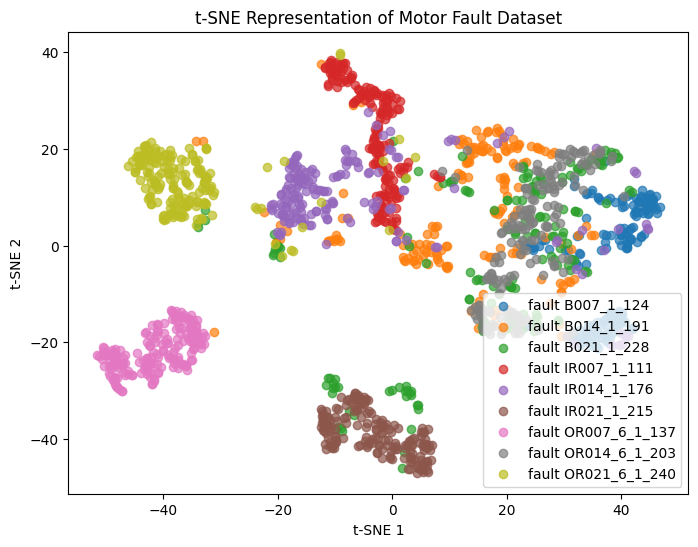

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [21]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,38.621414,-15.725605,B007_1_124
1,38.640255,-16.817499,B007_1_124
2,41.808556,-17.248552,B007_1_124
3,37.555050,-18.007557,B007_1_124
4,36.262810,9.448457,B007_1_124
...,...,...,...
1565,-39.167278,14.684276,OR021_6_1_240
1566,-40.717625,18.480539,OR021_6_1_240
1567,2.323227,14.056735,OR021_6_1_240
1568,-20.448925,0.398333,OR021_6_1_240


In [22]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,38.621414,-15.725605
1,38.640255,-16.817499
2,41.808556,-17.248552
3,37.555050,-18.007557
4,36.262810,9.448457
...,...,...
1565,-39.167278,14.684276
1566,-40.717625,18.480539
1567,2.323227,14.056735
1568,-20.448925,0.398333


In [23]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [24]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
784,12.341525,-23.394547,B007_1_124
1383,12.854080,-20.098133,B007_1_124
122,10.741319,-25.879927,B007_1_124
870,12.518214,-26.017153,B007_1_124
871,10.829607,-25.570276,B007_1_124
...,...,...,...
144,16.652750,18.995682,OR021_6_1_240
339,13.878169,13.896328,OR021_6_1_240
1444,14.699662,18.263641,OR021_6_1_240
567,19.062654,12.815113,OR021_6_1_240


Combined Features

In [25]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
784,-5.044305,9.021394,12.341525,-23.394547,B007_1_124
1383,18.172838,-2.387490,12.854080,-20.098133,B007_1_124
122,32.633923,-20.124416,10.741319,-25.879927,B007_1_124
870,44.297031,4.382257,12.518214,-26.017153,B007_1_124
871,19.431067,22.467793,10.829607,-25.570276,B007_1_124
...,...,...,...,...,...
144,43.456524,1.767082,16.652750,18.995682,OR021_6_1_240
339,-11.171915,0.903173,13.878169,13.896328,OR021_6_1_240
1444,-32.350132,14.032146,14.699662,18.263641,OR021_6_1_240
567,-0.428861,14.512167,19.062654,12.815113,OR021_6_1_240


In [26]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [27]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

In [28]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [29]:
pip install hyperactive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 6.7 MB/s eta 0:00:00


In [30]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


Deployment:

In [31]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
from hyperactive import Hyperactive
from hyperactive.optimizers import ParticleSwarmOptimizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === DATA: Replace X_train, X_test, y_train, y_test with your actual data ===
# Example:
# X_train, X_test, y_train, y_test = train_test_split(...)

X, y = X_train, y_train

# === Objective Function ===
def model(opt):
    CatBoost = CatBoostClassifier(
        iterations=opt["iterations"],
        depth=opt["depth"],
        learning_rate=opt["learning_rate"],
        l2_leaf_reg=opt["l2_leaf_reg"],
        bagging_temperature=opt["bagging_temperature"],
        random_strength=opt["random_strength"],
        verbose=False
    )
    scores = cross_val_score(CatBoost, X, y, cv=4)
    return scores.mean()

# === Search Space ===
search_space = {
    "iterations": list(range(50, 501, 50)),
    "depth": list(range(1, 11)),
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1, 1.5],
    "random_strength": [0.5, 1, 1.5],
}

# === Cauchy Mutation ===
def cauchy_mutation(particle, gamma=0.3):
    for key in particle:
        if isinstance(particle[key], (int, float)):
            particle[key] = particle[key] * (1 + gamma * np.tan(np.pi * (np.random.rand() - 0.5)))
            particle[key] = np.clip(particle[key], min(search_space[key]), max(search_space[key]))
            if isinstance(search_space[key][0], int):
                particle[key] = int(round(particle[key]))
    return particle

# === HSPSO Optimizer Class ===
class HybridStrategyPSO(ParticleSwarmOptimizer):
    def __init__(self, n_part=20, max_iter=40, **kwargs):
        super().__init__(**kwargs)
        self.switch_threshold = 10
        self.iteration = 0
        self.topology = "gbest"
        self.n_part = n_part
        self.max_iter = max_iter

        # Adaptive Inertia Parameters
        self.H = 1
        self.w_min = 0.4
        self.w_max = 0.9
        self.b = 0.9
        self.scaling_factor = 0.5

    def on_iteration(self, swarm, scores):
        self.iteration += 1

        # === Topology Switching ===
        if self.iteration % self.switch_threshold == 0:
            self.topology = "lbest" if self.topology == "gbest" else "gbest"
            self.set_topology(self.topology)

        # === Clone Best Particles ===
        best_indices = np.argsort(scores)[:max(1, len(swarm) // 5)]
        for idx in best_indices:
            particle = swarm[idx].copy()
            swarm.append(particle)
            scores.append(scores[idx])

        # === Prune Worst Particles ===
        if len(swarm) > 2 * self.n_part:
            worst_indices = np.argsort(scores)[-len(swarm)//4:]
            for i in reversed(worst_indices):
                del swarm[i]
                del scores[i]

        # === Nonlinear Adaptive Inertia ===
        numerator = (self.w_max - self.w_min) * self.iteration
        denominator = 1 + np.exp(-10 * self.b * ((2 * self.iteration) / (self.H * self.max_iter) - 1))
        self.inertia = self.w_max - numerator / denominator

        # === Cauchy Mutation ===
        for i in range(len(swarm)):
            if np.random.rand() < 0.2:
                swarm[i] = cauchy_mutation(swarm[i])

        # === Hook-Jeeves Local Search (simplified) ===
        top_ids = np.argsort(scores)[:2]
        for i in top_ids:
            particle = swarm[i]
            for key in particle:
                if isinstance(particle[key], (int, float)):
                    for delta in [-0.01, 0.01] if isinstance(particle[key], float) else [-1, 1]:
                        trial = particle.copy()
                        trial[key] = trial[key] + delta
                        trial[key] = np.clip(trial[key], min(search_space[key]), max(search_space[key]))
                        if isinstance(search_space[key][0], int):
                            trial[key] = int(round(trial[key]))
                        trial_score = model(trial)
                        if trial_score > scores[i]:
                            swarm[i] = trial
                            scores[i] = trial_score

        # === Random Restart ===
        if np.random.rand() < 0.1:
            random_idx = np.random.choice(len(swarm))
            for key in swarm[random_idx]:
                if isinstance(swarm[random_idx][key], (int, float)):
                    swarm[random_idx][key] = np.random.choice(search_space[key])

# === Run HSPSO Hyperparameter Tuning ===
start_time = datetime.now()

hyper = Hyperactive()

optimizer = HybridStrategyPSO(
    n_part=20,
    max_iter=40,
    inertia=0.5,
    cognitive_weight=0.9,
    social_weight=0.5,
    temp_weight=0.4,
    rand_rest_p=0.05,
)

hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40)
hyper.run()

end_time = datetime.now()
print('Tuning Duration:', end_time - start_time)

# === Best Parameters ===
best_params = hyper.best_para(model)
print("Best Parameters:", best_params)

# === Train Final Model with Best Parameters ===
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

final_model = CatBoostClassifier(
    depth=best_params["depth"],
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bagging_temperature=best_params["bagging_temperature"],
    random_strength=best_params["random_strength"],
    verbose=10
)

final_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=best_params["iterations"] // 10,
    plot=True
)


[0] model (Particle Swarm Optimization): 100%|──────────| 40/40 [03:38<00:00,  5.46s/it, best_iter=0, best_pos=None, best_score=-inf]



Results: 'model'  
   Best score: 0.9960191082802548  
   Best parameter set:
      'iterations'          : 350.0  
      'depth'               : 8.0  
      'learning_rate'       : 0.01  
      'l2_leaf_reg'         : 5.0  
      'bagging_temperature' : 0.5  
      'random_strength'     : 1.5  
   Best iteration: 0  
 
   Random seed: 797187591  
 
   Evaluation time   : 218.16915321350098 sec    [99.99 %]
   Optimization time : 0.012245416641235352 sec    [0.01 %]
   Iteration time    : 218.1813986301422 sec    [5.45 sec/iter]
 
Tuning Duration: 0:03:38.446176
Best Parameters: {'iterations': 350, 'depth': 8, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'bagging_temperature': 0.5, 'random_strength': 1.5}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1498662	test: 2.1509409	best: 2.1509409 (0)	total: 22.7ms	remaining: 7.91s
35:	learn: 1.2991765	test: 1.3179138	best: 1.3179138 (35)	total: 973ms	remaining: 8.49s
70:	learn: 0.8800167	test: 0.9010039	best: 0.9010039 (70)	total: 1.91s	remaining: 7.51s
105:	learn: 0.6324468	test: 0.6507423	best: 0.6507423 (105)	total: 2.7s	remaining: 6.21s
140:	learn: 0.4700617	test: 0.4845268	best: 0.4845268 (140)	total: 3.64s	remaining: 5.39s
175:	learn: 0.3609316	test: 0.3719056	best: 0.3719056 (175)	total: 5.39s	remaining: 5.33s
210:	learn: 0.2846152	test: 0.2926270	best: 0.2926270 (210)	total: 7.09s	remaining: 4.67s
245:	learn: 0.2285353	test: 0.2337435	best: 0.2337435 (245)	total: 7.94s	remaining: 3.36s
280:	learn: 0.1879593	test: 0.1909785	best: 0.1909785 (280)	total: 8.74s	remaining: 2.15s
315:	learn: 0.1579720	test: 0.1593338	best: 0.1593338 (315)	total: 9.71s	remaining: 1.04s
349:	learn: 0.1355494	test: 0.1354032	best: 0.1354032 (349)	total: 10.5s	remaining: 0us

bestTest = 0.135403

In [32]:
hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40, initialize={"random": 20})


In [33]:
learning_curve = final_model.get_evals_result()
print(learning_curve)

{'learn': {'MultiClass': [2.1498662015476384, 2.1158777866821548, 2.0820799624659654, 2.0480952962960264, 2.0065920566716713, 1.9693058845973777, 1.9374096415820259, 1.9050716829709056, 1.8757733392019251, 1.8501981968805166, 1.823980710116101, 1.8010718342123677, 1.772564116396938, 1.7551275422526076, 1.7343559522049903, 1.7097452038183183, 1.6791731321172565, 1.6635982440933348, 1.637196472343226, 1.609077407824916, 1.5842008847197167, 1.5630479934335715, 1.5408816767295603, 1.5173317457581055, 1.4992832976687451, 1.4841009501982936, 1.4641596778452661, 1.441223847741567, 1.424424555931857, 1.4069348203757346, 1.3866825708507655, 1.3721100983153525, 1.3552308161548072, 1.3386403940244416, 1.3188002370078225, 1.2991764833999817, 1.2799896592616289, 1.2638563828111438, 1.2507287859679521, 1.2366526639676567, 1.2201534066923583, 1.2081024439496846, 1.1944253737951742, 1.1825427518803284, 1.171321419333234, 1.157066349316384, 1.1456010643236694, 1.1324489490119365, 1.1177035721027733, 1.

In [34]:
# Retrieve evaluation results
learning_curve = final_model.get_evals_result()

# Extract the metric values
# Assuming 'learn' corresponds to the training dataset
train_metric_values = learning_curve.get('learn', {}).get('MultiClass', [])

# Check the extracted values
if train_metric_values:
    print("Training metric values:", train_metric_values)
else:
    print("Metric 'MultiClass' not found in evaluation results.")


Training metric values: [2.1498662015476384, 2.1158777866821548, 2.0820799624659654, 2.0480952962960264, 2.0065920566716713, 1.9693058845973777, 1.9374096415820259, 1.9050716829709056, 1.8757733392019251, 1.8501981968805166, 1.823980710116101, 1.8010718342123677, 1.772564116396938, 1.7551275422526076, 1.7343559522049903, 1.7097452038183183, 1.6791731321172565, 1.6635982440933348, 1.637196472343226, 1.609077407824916, 1.5842008847197167, 1.5630479934335715, 1.5408816767295603, 1.5173317457581055, 1.4992832976687451, 1.4841009501982936, 1.4641596778452661, 1.441223847741567, 1.424424555931857, 1.4069348203757346, 1.3866825708507655, 1.3721100983153525, 1.3552308161548072, 1.3386403940244416, 1.3188002370078225, 1.2991764833999817, 1.2799896592616289, 1.2638563828111438, 1.2507287859679521, 1.2366526639676567, 1.2201534066923583, 1.2081024439496846, 1.1944253737951742, 1.1825427518803284, 1.171321419333234, 1.157066349316384, 1.1456010643236694, 1.1324489490119365, 1.1177035721027733, 1.1

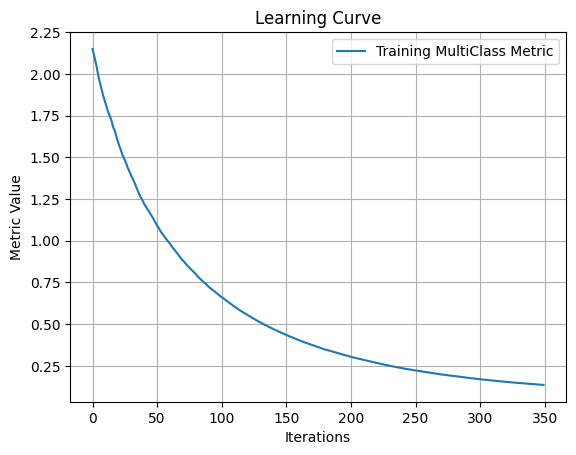

In [35]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.plot(train_metric_values, label='Training MultiClass Metric')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


Classification Report - Training Set:
               precision    recall  f1-score   support

   B007_1_124       1.00      1.00      1.00       136
   B014_1_191       1.00      0.97      0.99       144
   B021_1_228       0.97      1.00      0.99       138
  IR007_1_111       1.00      1.00      1.00       134
  IR014_1_176       1.00      1.00      1.00       139
  IR021_1_215       1.00      1.00      1.00       138
OR007_6_1_137       1.00      1.00      1.00       140
OR014_6_1_203       1.00      0.99      1.00       142
OR021_6_1_240       0.99      1.00      1.00       145

     accuracy                           1.00      1256
    macro avg       1.00      1.00      1.00      1256
 weighted avg       1.00      1.00      1.00      1256

Classification Report - Test Set:
               precision    recall  f1-score   support

   B007_1_124       1.00      1.00      1.00        32
   B014_1_191       1.00      1.00      1.00        32
   B021_1_228       1.00      1.00      1.00

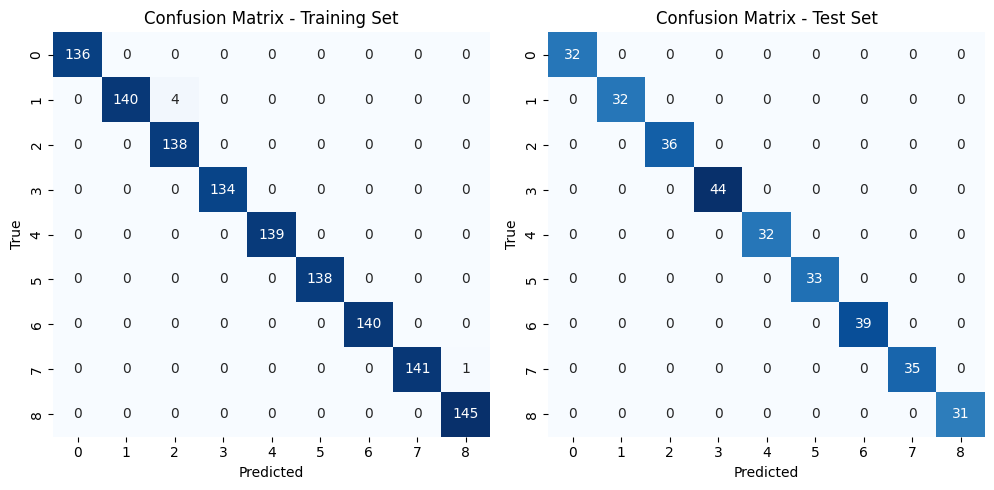

Deployment Duration: 0:03:50.743785


In [36]:
# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('C-Matrix.svg', format='svg')
plt.show()

end_time = datetime.now()
print('Deployment Duration: {}'.format(end_time - start_time))

In [37]:
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate train accuracy
result_train = final_model.score(X_train, y_train)
print("Train Accuracy : {}".format(result_train))

# Evaluate test accuracy
result_test = final_model.score(X_test, y_test)
print("Test Accuracy : {}".format(result_test))

# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

0:	learn: 2.1498662	test: 2.1509409	best: 2.1509409 (0)	total: 51.4ms	remaining: 17.9s
10:	learn: 1.8239807	test: 1.8333459	best: 1.8333459 (10)	total: 489ms	remaining: 15.1s
20:	learn: 1.5842009	test: 1.5994171	best: 1.5994171 (20)	total: 949ms	remaining: 14.9s
30:	learn: 1.3866826	test: 1.4048744	best: 1.4048744 (30)	total: 1.43s	remaining: 14.7s
40:	learn: 1.2201534	test: 1.2401248	best: 1.2401248 (40)	total: 1.93s	remaining: 14.5s
50:	learn: 1.0892364	test: 1.1110282	best: 1.1110282 (50)	total: 2.35s	remaining: 13.8s
60:	learn: 0.9797190	test: 1.0023979	best: 1.0023979 (60)	total: 2.76s	remaining: 13.1s
70:	learn: 0.8800167	test: 0.9010039	best: 0.9010039 (70)	total: 3.31s	remaining: 13s
80:	learn: 0.7978835	test: 0.8174570	best: 0.8174570 (80)	total: 3.95s	remaining: 13.1s
90:	learn: 0.7225547	test: 0.7416039	best: 0.7416039 (90)	total: 4.46s	remaining: 12.7s
100:	learn: 0.6619967	test: 0.6805755	best: 0.6805755 (100)	total: 5.43s	remaining: 13.4s
110:	learn: 0.6034674	test: 0.621